In [1]:
import numpy as np
import pandas as pd

import torch
from fastai import *
from fastai.vision import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
print(os.listdir("./Data"))

['test', 'train', 'train.csv']


In [2]:
bs = 64
path = Path('./Data')
path_train = path/'train'
path_test = path/'test'
path, path_train, path_test

(WindowsPath('Data'), WindowsPath('Data/train'), WindowsPath('Data/test'))

In [3]:
labels_df = pd.read_csv(path/'train.csv')
test_df = pd.read_csv('sample_submission.csv')
labels_df.head()
labels_df.describe()

,has_cactus
count,17500.000000
mean,0.750629
std,0.432662
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


In [5]:
np.random.seed(42)
test = ImageList.from_df(test_df, path=path_test)
data = (
    ImageList.from_df(labels_df, path=path_train)
                     .split_by_rand_pct(0.01)
                     .label_from_df()
                     .add_test(test)
                     .transform(get_transforms(
                         do_flip=True,
                         flip_vert = True,
                         max_rotate=10.0, 
                         max_zoom=1.1, 
                         max_lighting=0.2, 
                         p_affine=0.75, 
                         p_lighting=0.75,
                         max_warp = 0.), size = 128)
                     .databunch(path=path).normalize(imagenet_stats))
data

ImageDataBunch;

Train: LabelList (17325 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
1,1,1,1,1
Path: Data\train;

Valid: LabelList (175 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: CategoryList
0,0,0,1,1
Path: Data\train;

Test: LabelList (4000 items)
x: ImageList
Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128),Image (3, 128, 128)
y: EmptyLabelList
,,,,
Path: Data\train

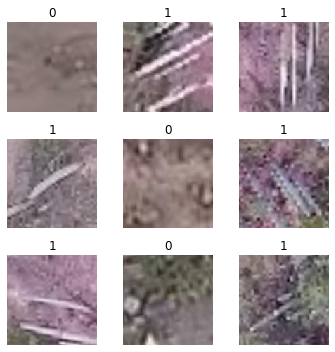

In [6]:
data.show_batch(rows = 3, figsize = (5,5))

In [7]:
data.classes

[0, 1]

In [8]:
learn = cnn_learner(data, models.resnet101, metrics = accuracy, model_dir='D:/AI/Workspace/KAGGLE/')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


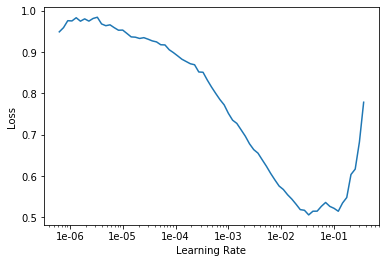

In [9]:
learn.lr_find()
learn.recorder.plot()

In [23]:
lr = 3e-02
learn.fit_one_cycle(10, slice(lr))

epoch,train_loss,valid_loss,accuracy,time
0,0.010077,0.004322,1.000000,02:39
1,0.031868,0.035944,0.994286,02:38
2,0.050592,0.418815,0.982857,02:38
3,0.032455,0.000395,1.000000,02:34
4,0.035249,0.021807,0.988571,02:35
5,0.013513,0.003725,1.000000,02:34
6,0.012520,0.000144,1.000000,02:32
7,0.003975,0.000939,1.000000,02:33
8,0.002788,0.000003,1.000000,02:36
9,0.001358,0.000005,1.000000,02:37


In [16]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [17]:
preds[:, 0]

tensor([3.4978e-07, 9.0803e-07, 1.0000e+00,  ..., 1.7906e-06, 4.3802e-08,
        1.4526e-05])

In [18]:
test_df['has_cactus'] = np.array(preds[:, 0])
test_df.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,3.497834e-07
1,0017242f54ececa4512b4d7937d1e21e.jpg,9.080310e-07
2,001ee6d8564003107853118ab87df407.jpg,1.000000e+00
3,002e175c3c1e060769475f52182583d0.jpg,1.000000e+00
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,9.778846e-06


In [19]:
test_df.to_csv('submission.csv', index = False)